In [4]:
import os  
import sys
sys.path.append("../")
from sunerf.model.mhd_model import MHDModel
import torch  
from sunerf.model.sunerf_lightning_classes import DensityTemperatureSuNeRFModule
from sunerf.data.fibonacci_sphere import fibonacci_sphere
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
# path to MHD datasets
data_path = '/mnt/disks/data/mhd'

# define baseline un-trained MHD model
mhd_model = MHDModel(data_path=data_path)
# print(output_density, output_temperature)


In [6]:
# path to last checkpoint
checkpoint_path = "/mnt/disks/data/checkpoints/aia_iti_512_log_psi/save_state.snf"

# load SuNeRF model
sunerf_model = torch.load(checkpoint_path)

print(sunerf_model)

/var/tmp/ipykernel_208773/2897582893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sunerf_model = torch.load(checkpoint_path)


{'rendering': DensityTemperatureRadiativeTransfer(
  (sampler): StratifiedSampler()
  (sampler_hierarchical): HierarchicalSampler()
  (coarse_model): NeRF_DT(
    (act): Sine()
    (in_layer): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=84, out_features=512, bias=True)
    )
    (layers): ModuleList(
      (0-6): 7 x Linear(in_features=512, out_features=512, bias=True)
    )
    (out_layer): Linear(in_features=512, out_features=2, bias=True)
  )
  (fine_model): NeRF_DT(
    (act): Sine()
    (in_layer): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=84, out_features=512, bias=True)
    )
    (layers): ModuleList(
      (0-6): 7 x Linear(in_features=512, out_features=512, bias=True)
    )
    (out_layer): Linear(in_features=512, out_features=2, bias=True)
  )
  (response): ParameterDict(
      (0_131_LOGTE): Parameter containing: [torch.cuda.FloatTensor of size 101 (cuda:0)]
      (0_131_TRESP): Parameter containing: [torch.cuda.F

In [23]:
n_layers = 6 # how many concentric shells  
delta_r = .3 # disntance b/w shells in solar radii 

# define coordinates of the sphere
coordinates = []
for i in range(n_layers):
    coordinates.append(np.array(fibonacci_sphere(np.random.randint(1200, 4200)))*(1 + i*delta_r/(n_layers-1)))

# write coords to array    
coordinates = np.concatenate(coordinates)
x = coordinates[:,0]
y = coordinates[:,1]
z = coordinates[:,2]

# radius
r = np.sqrt(x**2 + y**2 + z**2)
 
# only keeping the coords for which radius>1 
x = x[r>1]
y = y[r>1]
z = z[r>1]
r = r[r>1]

# concatinate coordinates to query form ([x, y, z, t])
t = z[:,None]*0 # create query time placeholder
coordinates_mhd = np.concatenate((x[:,None], y[:,None], z[:,None], t), axis=1)
# coordinates.shape >> (12286, 4)

# convert coordinates to torch tensor and convert to float objs
coordinates_mhd = torch.tensor(coordinates_mhd).cuda().to(torch.float32)


coordinates_sunerf = np.concatenate((x[:,None], y[:,None], z[:,None], t-7), axis=1)
# coordinates.shape >> (12286, 4)

# convert coordinates to torch tensor and convert to float objs
coordinates_sunerf = torch.tensor(coordinates_sunerf).cuda().to(torch.float32)


In [24]:
sunerf_model.keys()

dict_keys(['rendering', 'data_config', 'Rs_per_ds', 'seconds_per_dt', 'ref_time'])

In [25]:
# load queries into sunerf model
sunerf_output = sunerf_model["rendering"].fine_model.forward(coordinates_sunerf)

# get temperature, density for sunerf
t_nerf = sunerf_output['RhoT'][:,1].detach().cpu().numpy()
rho_nerf = sunerf_output['RhoT'][:,0].detach().cpu().numpy()

# check
sunerf_output

{'RhoT': tensor([[16.9980,  5.2997],
         [18.9753,  5.0558],
         [16.8662,  5.3378],
         ...,
         [15.4927,  6.1537],
         [15.0375,  5.8285],
         [16.2242,  5.8092]], device='cuda:0', grad_fn=<CopySlices>),
 'log_abs': Parameter containing:
 tensor([[15.0104, 16.4503, 16.4804],
         [15.0793, 16.5092, 16.5409],
         [15.0416, 16.9238, 17.0054],
         [15.0508, 15.3267, 15.2980],
         [15.0620, 14.0000, 14.0000],
         [15.2537, 14.0000, 14.0000],
         [15.1393, 14.0000, 14.0000]], device='cuda:0', requires_grad=True),
 'vol_c': Parameter containing:
 tensor([2.6940, 5.0119, 4.8220], device='cuda:0', requires_grad=True)}

In [26]:
# load queries into mhd model
mhd_output = mhd_model.forward(coordinates_mhd)

# get temperature, density for mhd model
t_mhd = mhd_output['RhoT'][:,1].detach().cpu().numpy()
rho_mhd = mhd_output['RhoT'][:,0].detach().cpu().numpy()

# check
mhd_output 


{'RhoT': tensor([[29.0173,  4.1962],
         [29.1755,  4.1709],
         [29.0173,  4.2141],
         ...,
         [17.6124,  6.2325],
         [17.5675,  6.2310],
         [17.6312,  6.2465]], device='cuda:0'),
 'log_abs': Parameter containing:
 tensor([[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.]], requires_grad=True),
 'vol_c': Parameter containing:
 tensor([1., 1., 1.], requires_grad=True)}

In [27]:
def perfect_axis(ax, x, y):
    ''' create square plots with equal x/y axes'''

    plot_dim = max([max(x), max(y), abs(min(x)), abs(min(y))])
    print(f"dimension: {plot_dim}")
    ax.set_xlim([-plot_dim, plot_dim])
    ax.set_ylim([-plot_dim, plot_dim])
    ax.set_aspect("equal")
    

Text(0.5, 1.0, 'Density')

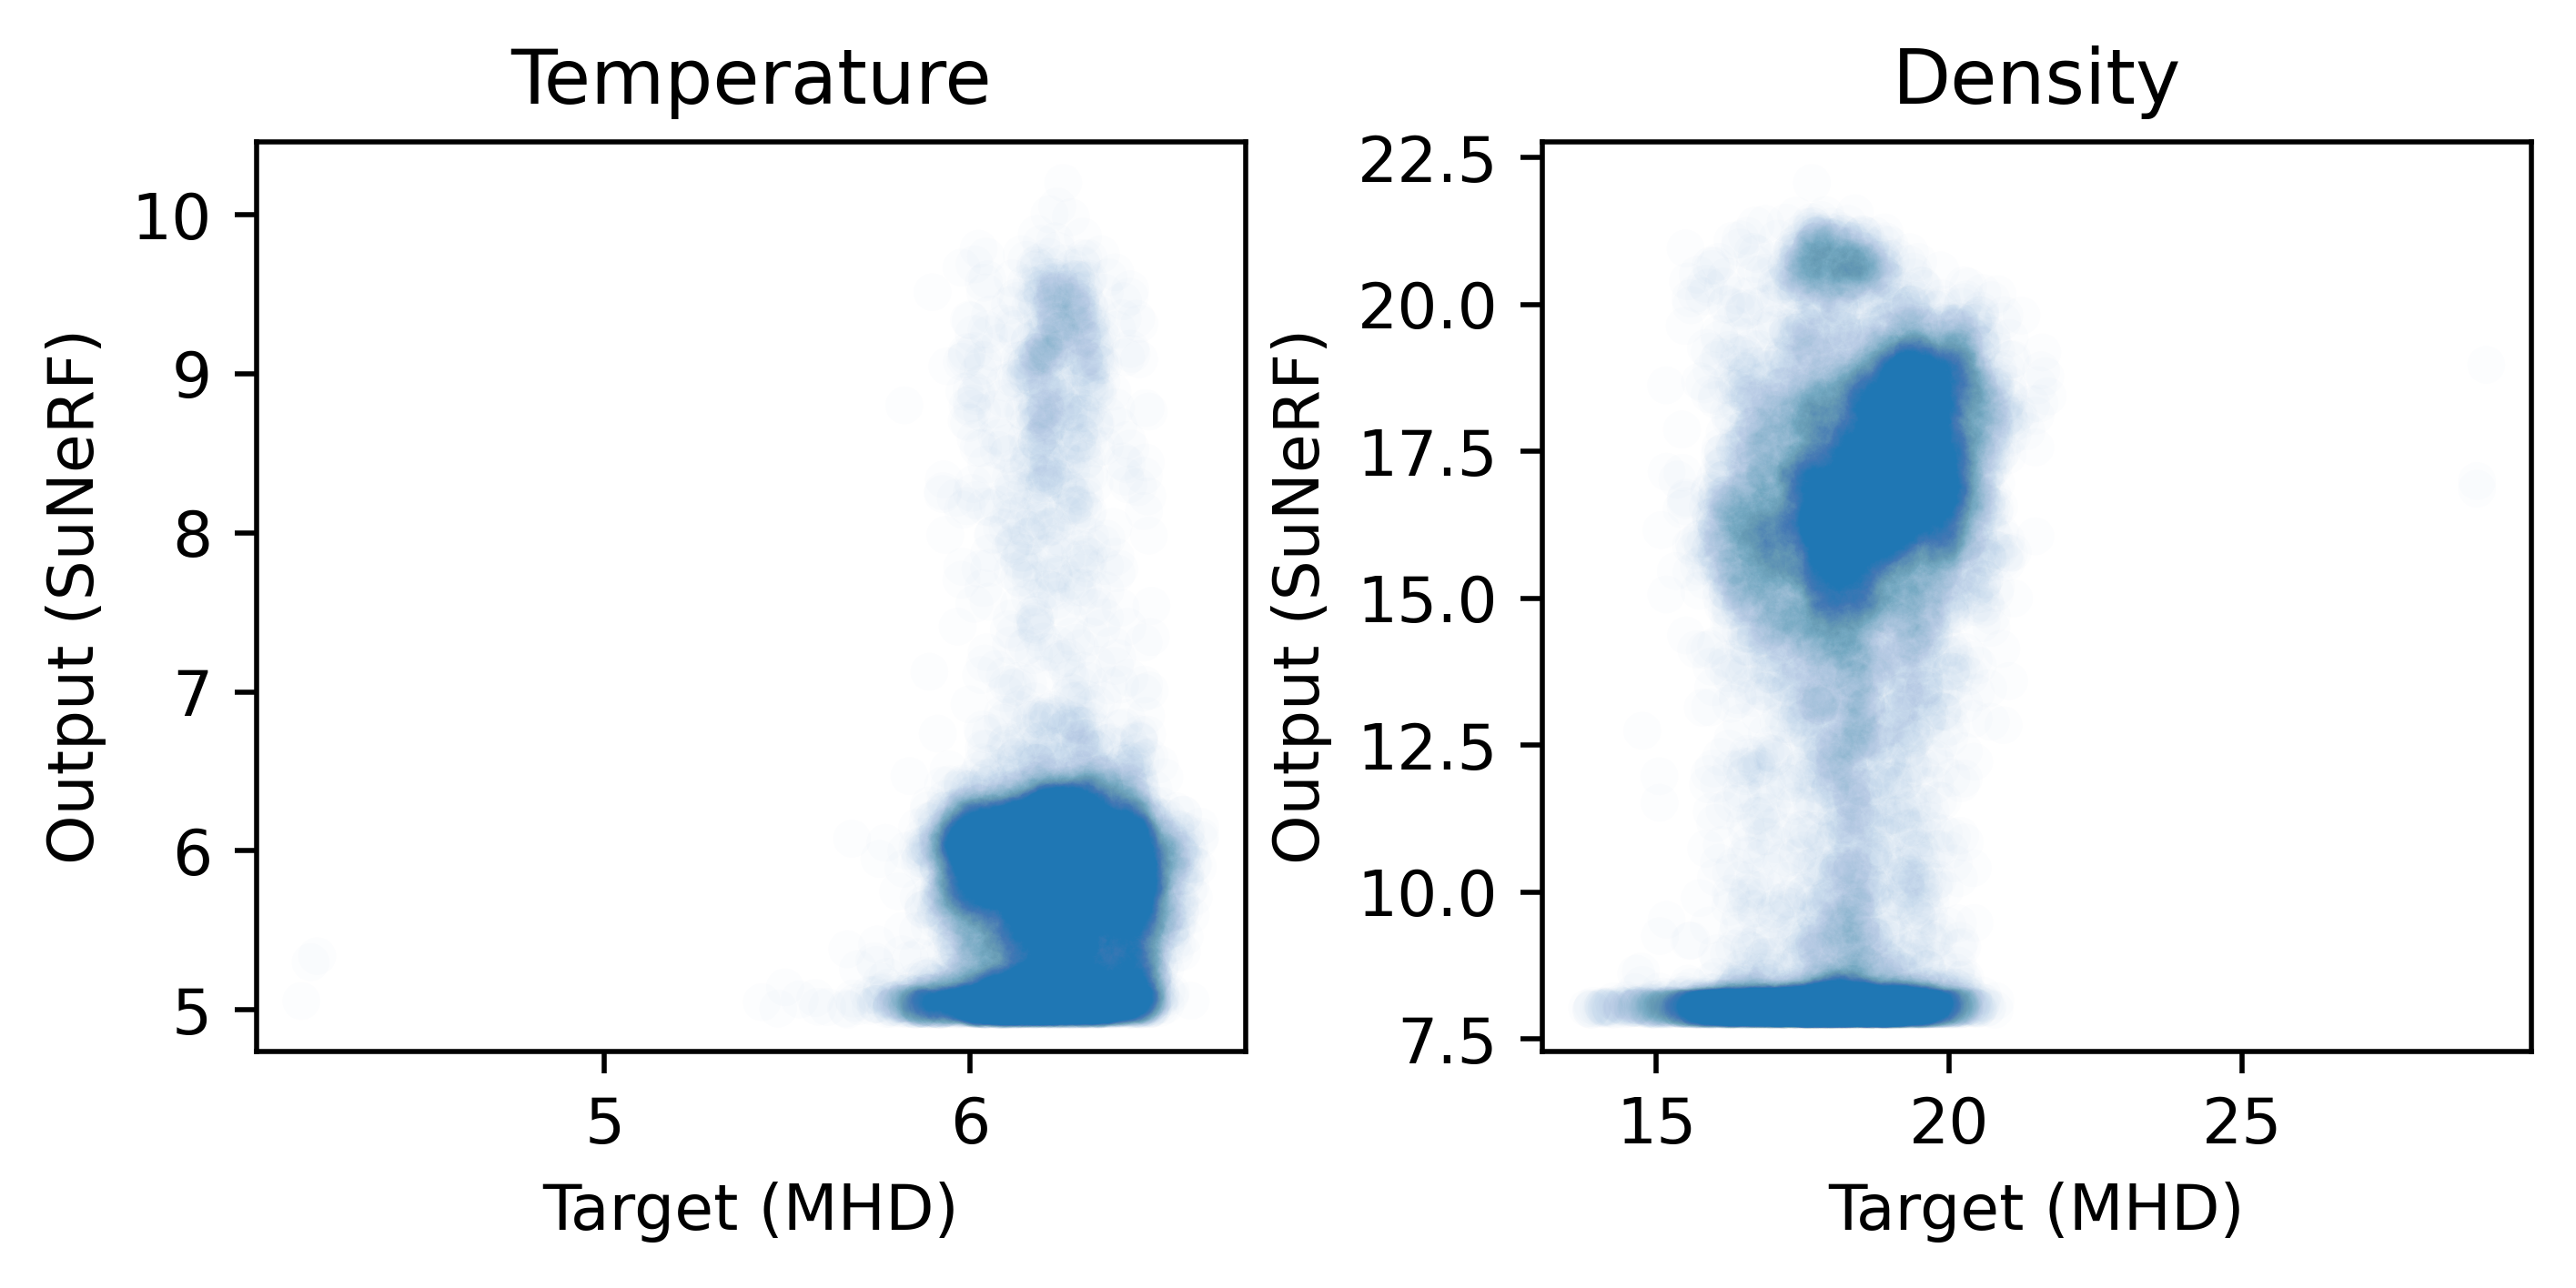

In [28]:
# SCATTER PLOT

# set up figure
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

# plot temperatures for mhd and sunerf
ax = fig.add_subplot(gs0[0, 0])

# Temperature 
ax.scatter(t_mhd, t_nerf, alpha=0.01, ec='None')
# perfect_axis(ax, t_mhd, t_nerf)
# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Temperature')

# plot densitiesfor mhd and sunerf
ax = fig.add_subplot(gs0[0, 1])
ax.scatter(rho_mhd, rho_nerf, alpha=0.01, ec='None')
# perfect_axis(ax, rho_mhd, rho_nerf)
# ax.plot([5,9],[5,9], '--k')

ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Density')

#print('MAE T', np.nanmean(np.abs(output_f[0][:,1].detach().cpu().numpy()+base_temp-te_at_locs)))
#print('MAE n', np.nanmean(np.abs(density_f.detach().cpu().numpy()-ne_at_locs)))

/var/tmp/ipykernel_208773/2318978944.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('magma_r').copy()


Text(0.5, 1.0, 'Log$_{10}$ T')

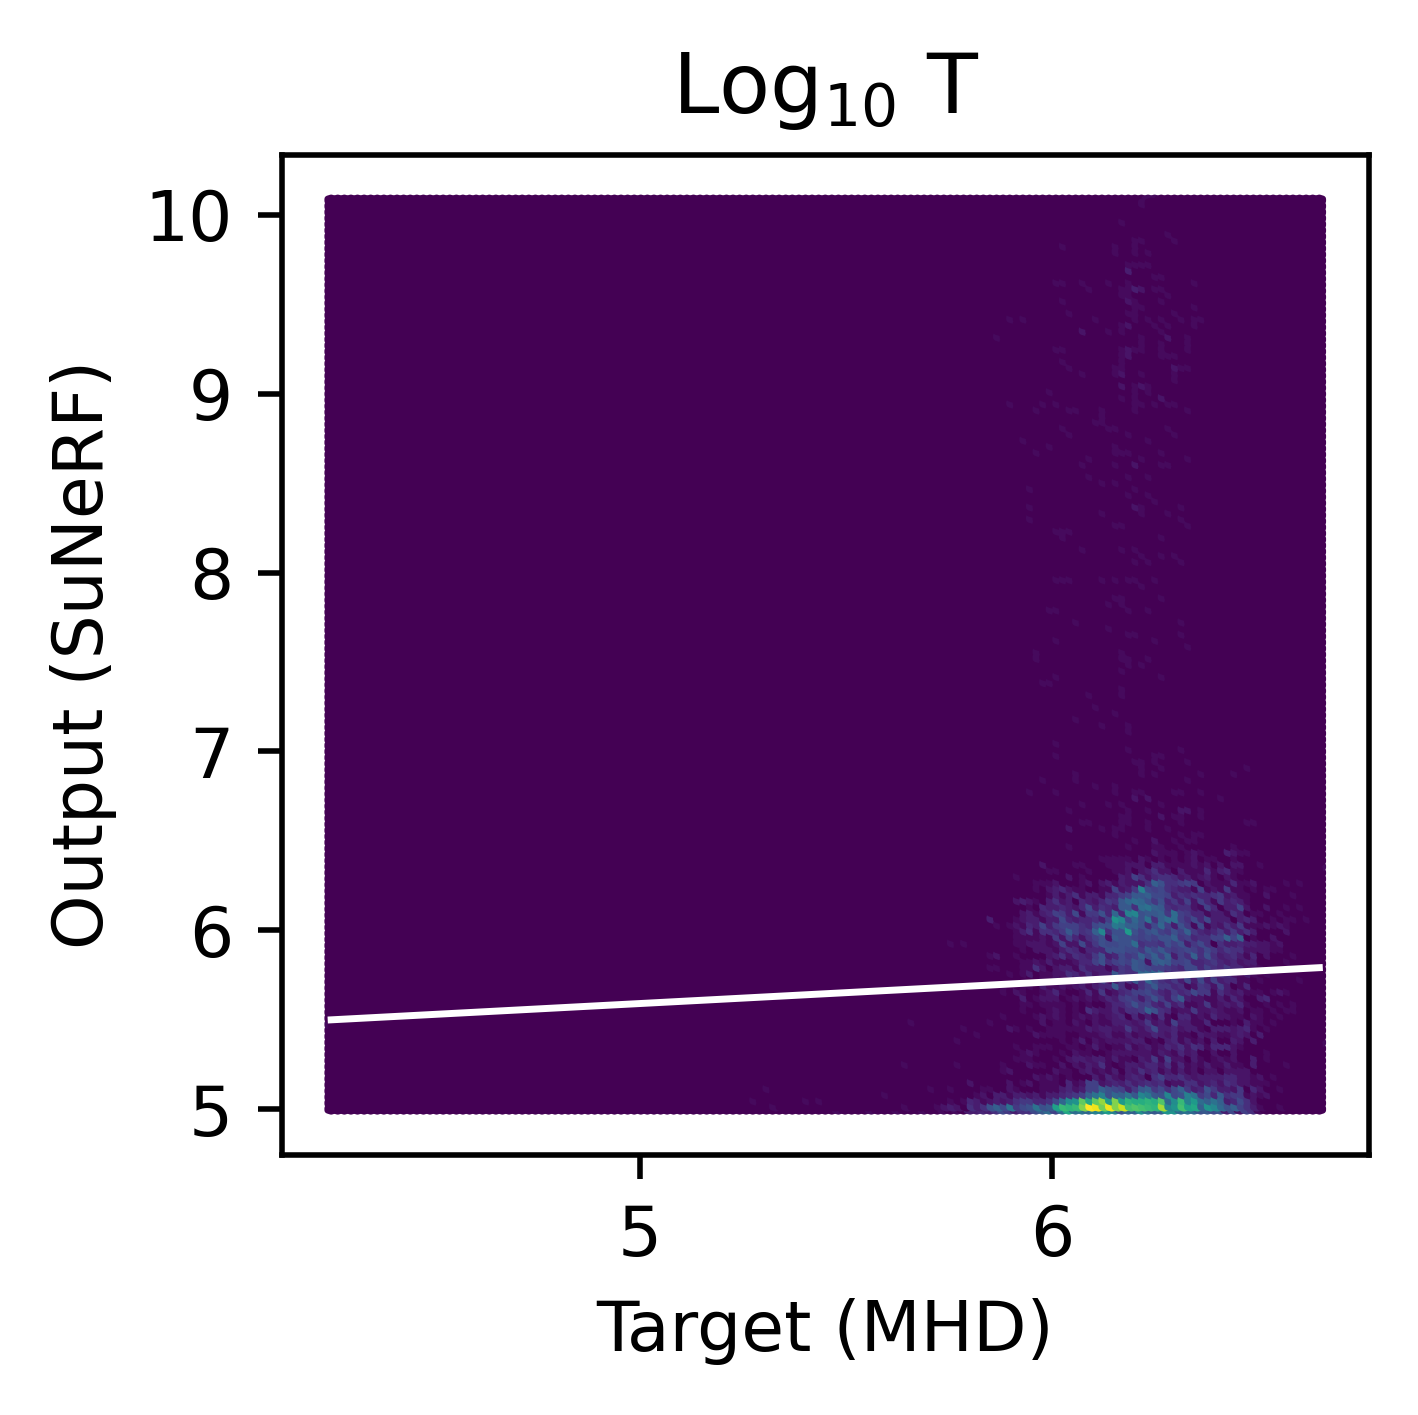

In [15]:
# 2D Histogram Plot

fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

x1 = 4.2
x2 = 5.4
nbins = 100

xbins = np.linspace(x1, x2, nbins)

cmap = mpl.cm.get_cmap('magma_r').copy()
cmap.set_under('w',1)

# histogram for target and output
# ax.hist2d(t_mhd, t_nerf, bins=xbins, cmap=cmap, cmin=1)
ax.hexbin(t_mhd, t_nerf, gridsize=(150, 150))

# polyfit line
ax.plot(np.unique(t_mhd),
        np.poly1d(np.polyfit(t_mhd, t_nerf, 1))(np.unique(t_mhd)),
        c="w",
        linewidth=1,
        )

# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_facecolor('w')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Log$_{10}$ T')


# x1 = 
# x2 = 9
# nbins = 100

# xbins = np.linspace(x1, x2, nbins)

# ax = fig.add_subplot(gs0[0, 1])
# # ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
# ax.hist2d(ne_at_locs, density_f.detach().cpu().numpy(), bins=xbins, cmap=cmap, cmin=1)
# ax.plot([5,9],[5,9], '--k')
# ax.set_facecolor('w')

# ax.set_xlabel('Target (MHD)')
# ax.set_ylabel('Output (SuNeRF)')
# ax.set_title('Log$_{10}$ n')

x1, x2 (-5, 5)


Text(0.5, 1.0, 'Log$_{10}$ Rho')

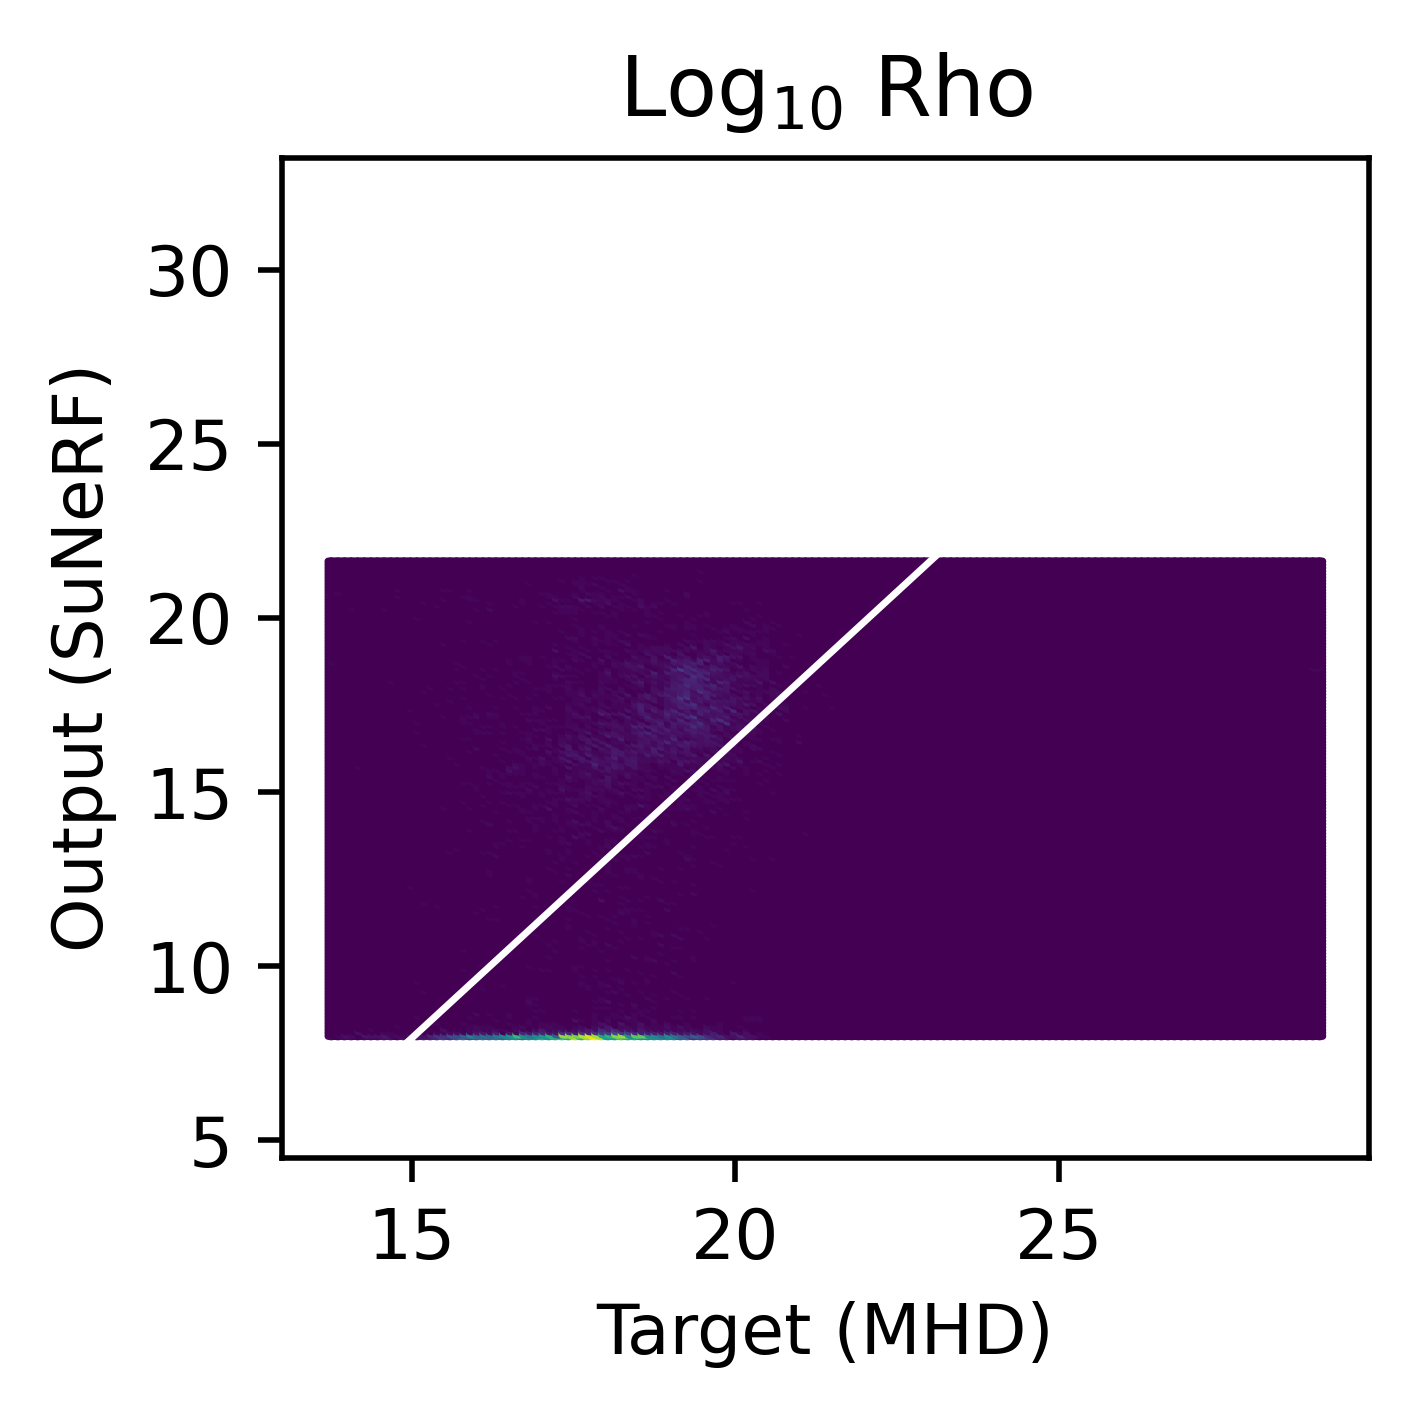

In [16]:
# Density 
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)


x1 = -5
x2 = 5
print(f"x1, x2 {x1, x2}")
nbins = 100

xbins = np.linspace(x1, x2, nbins)

ax = fig.add_subplot(gs0[0, 0])

# ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
# histogram for target and output
# ax.hist2d(rho_mhd, rho_nerf, bins=xbins, cmap=cmap, cmin=1)
ax.hexbin(rho_mhd, rho_nerf, gridsize=(150, 150))

# polyfit line
ax.plot(np.unique(rho_mhd),
        np.poly1d(np.polyfit(rho_mhd, rho_nerf, 1))(np.unique(rho_mhd)),
        c="w",
        linewidth=1,
        )

# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_facecolor('w')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Log$_{10}$ Rho')